# Model Selection

This notebook starts with conditioned data. The data is not yet in the "wide" table that would show several preceeding hours of data. I wanted to start with the simple hour prediction to see how accurate of a model could be made.

In [1]:
import seaborn as sns
import os
import math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import glob
import dateutil
import datetime 
from datetime import date, timedelta

from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, validation_curve
from sklearn.linear_model import *
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

In [2]:
df = pd.read_csv('combined_data.csv')
df.describe()

,Unnamed: 0,dayIndex,hourIndex,hSamples,usage,weatherAES,dayIndexEco,hourIndexEco,fiveMinSamples,coolSet,...,wind,coolStage1,heatStage1,auxStage1,fan,thermT,thermHum,thermMotion,sensT,sensMotion
count,5112.000000,5112.000000,5112.000000,5112.000000,5112.000000,4889.000000,5112.000000,5112.000000,5112.00000,5111.000000,...,5107.0,5088.000000,5088.00000,5088.000000,5088.000000,5111.000000,5111.000000,5088.000000,5111.000000,5088.000000
mean,2555.500000,106.000000,11.500000,0.956573,0.929731,47.176314,106.000000,11.500000,12.00000,71.244617,...,0.0,172.051887,128.23408,34.121462,368.785377,68.620869,42.145783,1.482508,68.068197,0.637382
std,1475.851619,61.493141,6.922864,0.204794,0.956718,16.448427,61.493141,6.922864,0.23738,1.202573,...,0.0,454.616747,366.88327,210.080429,615.605753,2.013736,6.533781,2.007184,2.533958,1.761143
min,0.000000,0.000000,0.000000,0.000000,0.000000,-4.000000,0.000000,0.000000,0.00000,65.000000,...,0.0,0.000000,0.00000,0.000000,0.000000,64.233333,21.000000,0.000000,62.541667,0.000000
25%,1277.750000,53.000000,5.750000,1.000000,0.231600,35.000000,53.000000,5.750000,12.00000,70.000000,...,0.0,0.000000,0.00000,0.000000,0.000000,66.920833,37.250000,0.000000,65.866667,0.000000
50%,2555.500000,106.000000,11.500000,1.000000,0.597600,46.000000,106.000000,11.500000,12.00000,71.500000,...,0.0,0.000000,0.00000,0.000000,0.000000,68.225000,42.750000,0.000000,67.875000,0.000000
75%,3833.250000,159.000000,17.250000,1.000000,1.267200,59.000000,159.000000,17.250000,12.00000,71.516667,...,0.0,0.000000,0.00000,0.000000,585.000000,70.358333,48.000000,3.000000,70.366667,0.000000
max,5111.000000,212.000000,23.000000,2.000000,8.226000,90.000000,212.000000,23.000000,24.00000,73.000000,...,0.0,3600.000000,3600.00000,3600.000000,3600.000000,74.908333,55.500000,11.000000,74.908333,12.000000


# Data Exploration and Visualization

1. Identify the good data only, that is the rows with 1 hSamples and 12 fiveMinSamples -> used pd.dropna
2. plot the pairplot of most important variable
3. try fitting a regression model using the "most important variables"
4. retry models while using various parameters

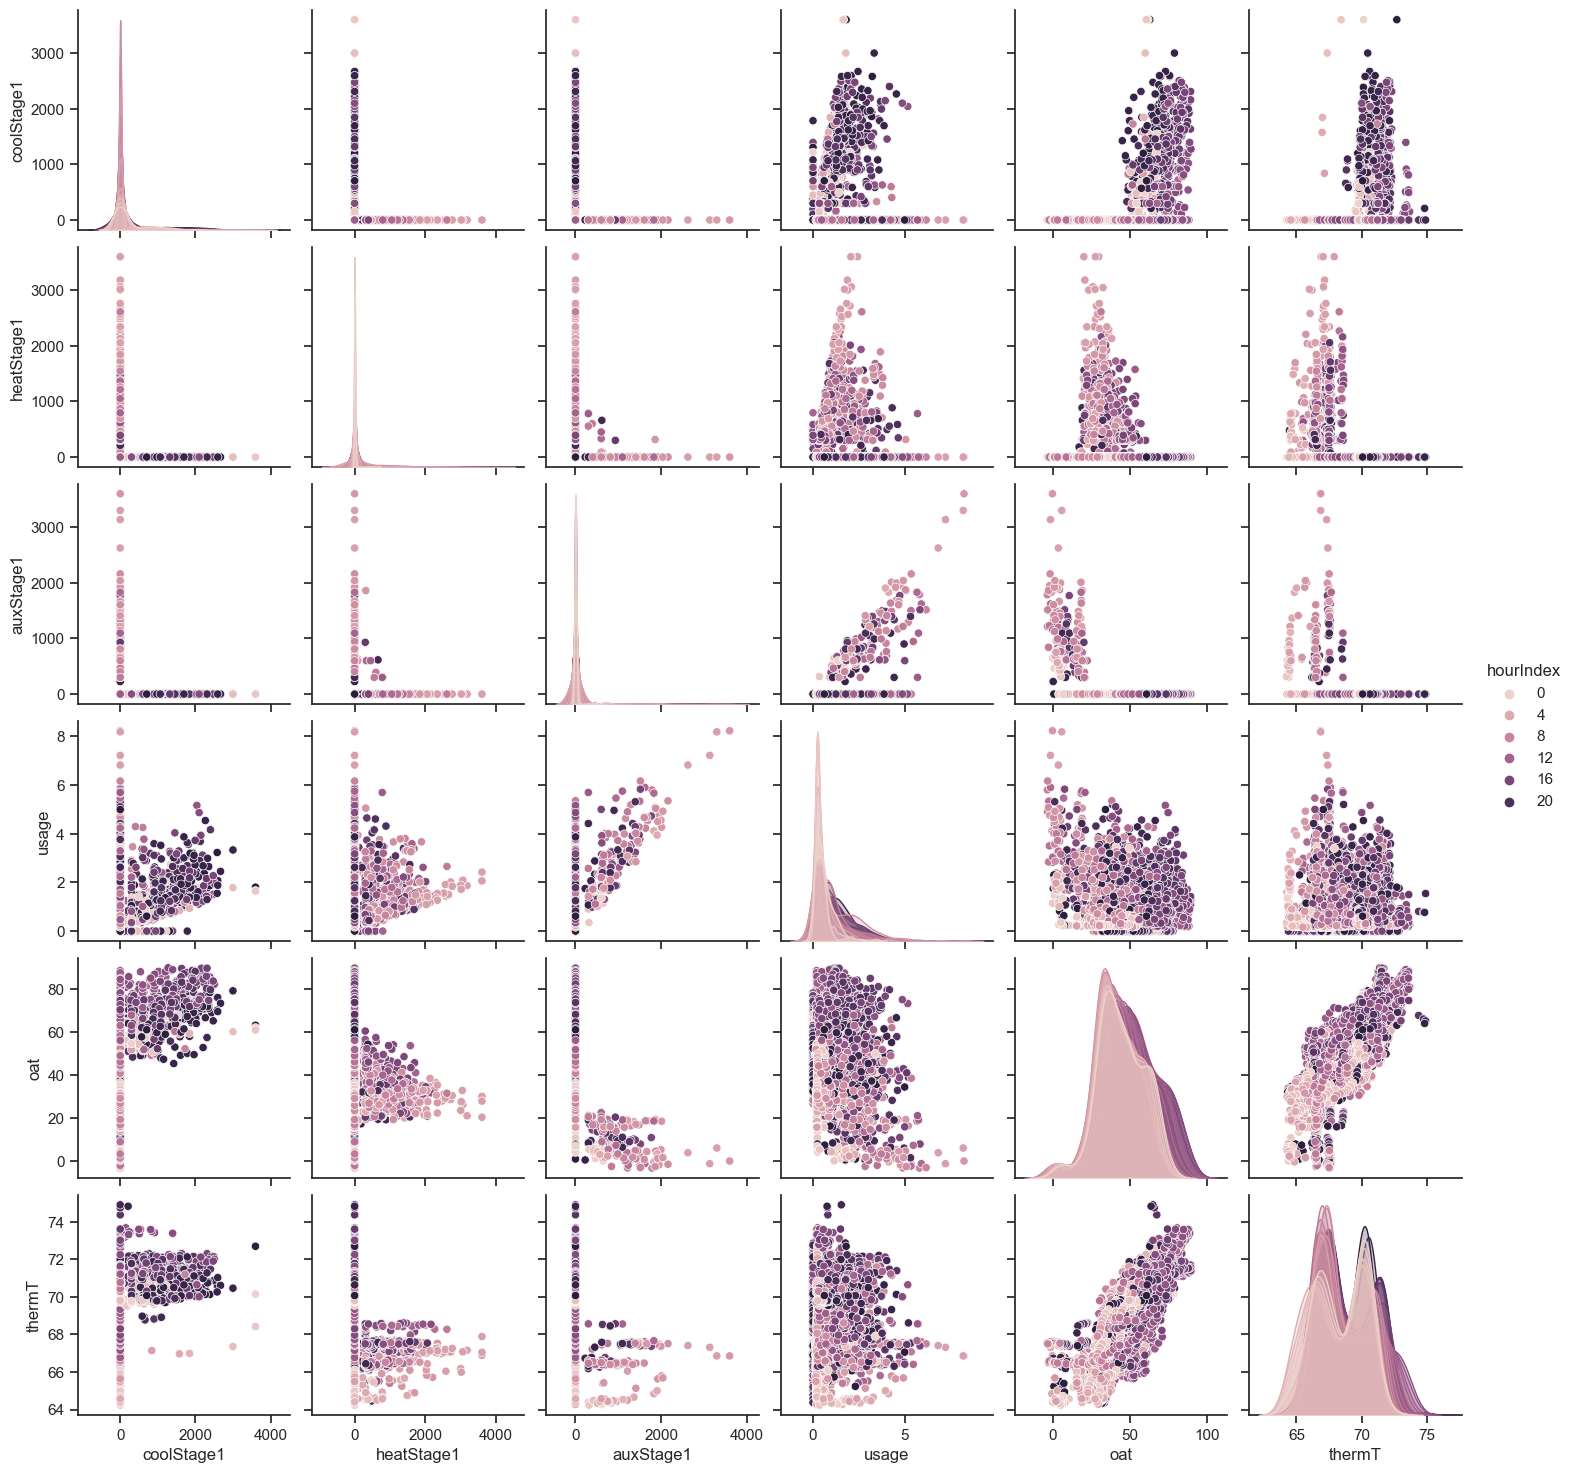

In [3]:
smallDataset = ["hourIndex","coolStage1", "heatStage1", "auxStage1", "usage", "oat", "thermT"]
smalldf = df[smallDataset].dropna()
sns.set_theme(style="ticks")

sns.pairplot(smalldf, hue="hourIndex")

In [4]:
from sklearn.model_selection import train_test_split

X = smalldf.drop('usage', axis=1)
y = smalldf.usage

train, test = train_test_split(smalldf, test_size=0.2)
X_train = train.drop('usage', axis=1)
y_train = train.usage

X_test = test.drop('usage', axis=1)
y_test = test.usage

Mean squared error (test error): 0.50
Coefficient of determination: 0.43
Mean score of 0.40 with a standard deviation of 0.03


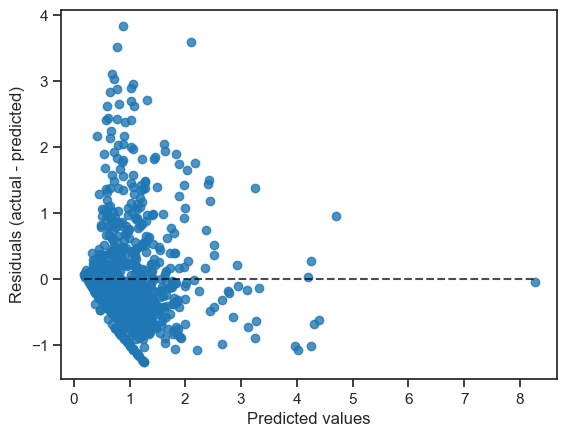

In [5]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import PredictionErrorDisplay

linModel = LinearRegression()
linModel.fit(X_train, y_train)
Y_pred = linModel.predict(X_test)

print("Mean squared error (test error): %.2f" % mean_squared_error(y_test, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, Y_pred))

k_fold = RepeatedKFold(n_splits=3)
scores = cross_val_score(linModel, X, y, cv=k_fold)
print("Mean score of %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

display = PredictionErrorDisplay(y_true=y_test, y_pred=Y_pred)
display.plot()
plt.show()

In [6]:
a = np. logspace(-5,5,1000)
lassoModel = LassoCV(alphas=a)
lassoModel.fit(X_train, y_train)
Y_hat = lassoModel.predict(X_test)

print("Mean squared error (test error): %.2f" % mean_squared_error(y_test, Y_hat))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, Y_hat))
print("There are %i non-zero coefficients" % sum(lassoModel.coef_ != 0))

print(lassoModel.coef_)
scores = cross_val_score(lassoModel, X, y, cv=k_fold)
print("Mean score of %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


Mean squared error (test error): 0.50
Coefficient of determination: 0.43
There are 6 non-zero coefficients
[ 0.03615339  0.00060433  0.00042364  0.00197355 -0.01562232  0.05130906]
Mean score of 0.40 with a standard deviation of 0.02


# Analysis

I tried to include the most important variables based on what I thought would be best from my knowledge of HVAC. This produced... a model... Next, I probably need to take a more balanced approach to how to select parameters.

up to this point, I included both cooling and heating in the same training dataset. Cooling and Heating are mutually exclusive. So maybe there needs to be separate heating and cooling models. For the most part, it will be unlikely that both heating and cooling will happen within the same hour. I will throw that data out since it might only affect a few observations.

In [26]:
heatFilt = smalldf.heatStage1 > 0
auxFilt = smalldf.auxStage1 > 0
coolFilt = smalldf.coolStage1 > 0
print("hours with heat =", sum(heatFilt))
print("hours with aux =",sum(auxFilt))
print("hours with cool =", sum(coolFilt))

print(sum(heatFilt | auxFilt | coolFilt))

heatdf = smalldf.loc[heatFilt]
auxdf = smalldf.loc[auxFilt]
cooldf = smalldf.loc[coolFilt]

Modedfs = [heatdf, auxdf, cooldf]

hours with heat = 838
hours with aux = 172
hours with cool = 852
1851


Mean squared error (test error): 0.50
Coefficient of determination: 0.39
Mean score of 0.22 with a standard deviation of 0.04


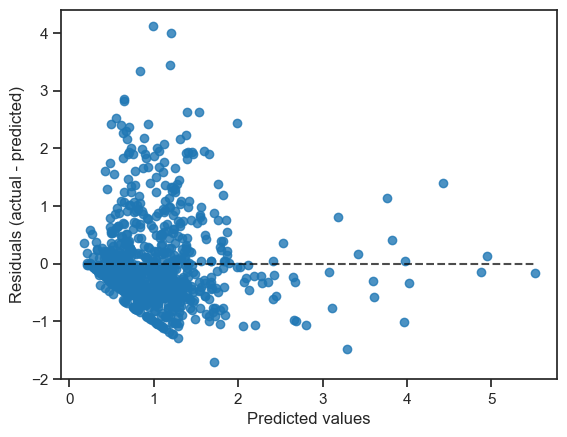

Mean squared error (test error): 0.51
Coefficient of determination: 0.40
Mean score of 0.66 with a standard deviation of 0.08


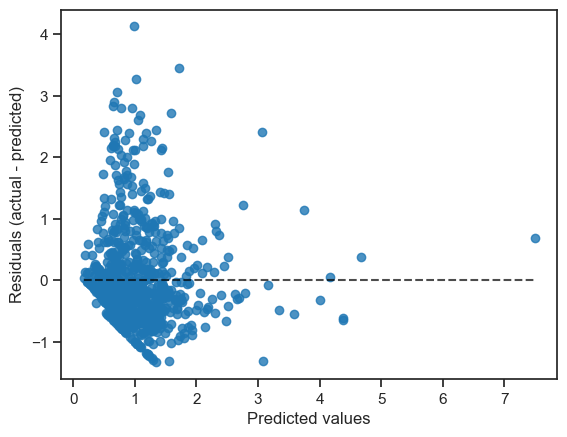

Mean squared error (test error): 0.47
Coefficient of determination: 0.48
Mean score of 0.32 with a standard deviation of 0.04


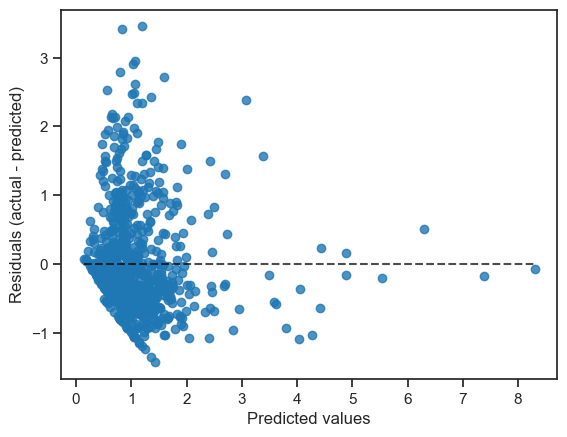

In [8]:
for thisMode in Modedfs:
    X = thisMode.drop('usage', axis=1)
    y = thisMode.usage

    train, test = train_test_split(smalldf, test_size=0.2)
    X_train = train.drop('usage', axis=1)
    y_train = train.usage

    X_test = test.drop('usage', axis=1)
    y_test = test.usage
    
    
    linModel = LinearRegression()
    linModel.fit(X_train, y_train)
    Y_pred = linModel.predict(X_test)

    print("Mean squared error (test error): %.2f" % mean_squared_error(y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print("Coefficient of determination: %.2f" % r2_score(y_test, Y_pred))

    k_fold = RepeatedKFold(n_splits=3)
    scores = cross_val_score(linModel, X, y, cv=k_fold)
    print("Mean score of %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

    display = PredictionErrorDisplay(y_true=y_test, y_pred=Y_pred)
    display.plot()
    plt.show()

# Wide Matrix Creation

In [9]:
colNames = smalldf.columns
minusNums = ['_1','_2','_3','_4']

n=4

shiftdf =[]
repeatRow = smalldf.iloc[[0]]
thisdf =smalldf
for i in range(n):
    thisdf = pd.concat([repeatRow, thisdf], ignore_index=True)
    dictionary = dict(zip(colNames.to_list(), (colNames + minusNums[i]).to_list()))
    newdf = thisdf.rename(columns=dictionary)
    #print(newdf.columns)
    shiftdf.append(newdf)
    

widedf = smalldf.join(shiftdf[:])
#now remove the top and bottom 4 rows

widedf.drop(widedf.tail(n).index,inplace=True) # drop last n rows
widedf.drop(widedf.head(n).index,inplace=True) # drop first n rows

#the widedf now includes the preceeding 4 hours for each observation
widedf.head()
widedf=widedf.dropna()

In [10]:
from sklearn.model_selection import train_test_split

X = widedf.drop('usage', axis=1)
y = widedf.usage

train, test = train_test_split(widedf, test_size=0.2)
X_train = train.drop('usage', axis=1)
y_train = train.usage

X_test = test.drop('usage', axis=1)
y_test = test.usage

In [23]:
widedf[["oat","oat_1","oat_2","oat_3","oat_4"]]

,oat,oat_1,oat_2,oat_3,oat_4
4,59.25,60.20,62.05,63.45,65.00
5,58.25,59.25,60.20,62.05,63.45
6,56.75,58.25,59.25,60.20,62.05
7,56.55,56.75,58.25,59.25,60.20
8,58.20,56.55,56.75,58.25,59.25
...,...,...,...,...,...
5079,74.90,68.00,68.20,67.60,66.10
5080,75.20,64.50,68.00,68.20,67.60
5081,75.20,62.50,64.50,68.00,68.20
5082,73.60,61.30,62.50,64.50,68.00


Mean squared error (test error): 0.51
Coefficient of determination: 0.41
Mean score of 0.41 with a standard deviation of 0.03


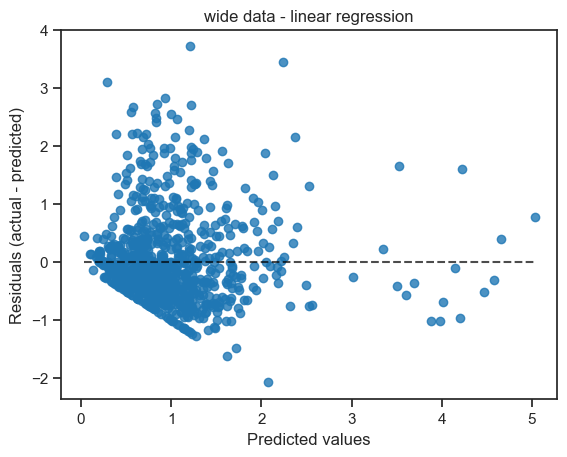

In [76]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import PredictionErrorDisplay

linModel = LinearRegression()
linModel.fit(X_train, y_train)
Y_pred = linModel.predict(X_test)

print("Mean squared error (test error): %.2f" % mean_squared_error(y_test, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, Y_pred))

k_fold = RepeatedKFold(n_splits=3)
scores = cross_val_score(linModel, X, y, cv=k_fold)
print("Mean score of %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

display = PredictionErrorDisplay(y_true=y_test, y_pred=Y_pred)
display.plot()
plt.title("wide data - linear regression")
plt.show()


# Regression Trees on single hour dataset
Using the lab example from the book...

In [12]:
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset 
import sklearn.model_selection as skm

from sklearn.tree import (DecisionTreeClassifier as DTC, DecisionTreeRegressor as DTR,
plot_tree ,
export_text)
from sklearn.metrics import (accuracy_score ,
log_loss) 
from sklearn.ensemble import \
(RandomForestRegressor as RF, GradientBoostingRegressor as GBR)

from ISLP import load_data , confusion_table 
from ISLP.models import ModelSpec as MS

In [13]:
model = MS(smalldf.columns.drop('usage'), intercept=False) 
D = model.fit_transform(smalldf)
feature_names = list(D.columns)
X = np.asarray(D)

In [15]:
from sklearn.model_selection import train_test_split

X = smalldf.drop('usage', axis=1)
y = smalldf.usage

train, test = train_test_split(smalldf, test_size=0.2)
X_train = train.drop('usage', axis=1)
y_train = train.usage

X_test = test.drop('usage', axis=1)
y_test = test.usage

In [22]:
# train, test already created
print(feature_names)
X_train

['hourIndex', 'coolStage1', 'heatStage1', 'auxStage1', 'oat', 'thermT']


,hourIndex,coolStage1,heatStage1,auxStage1,oat,thermT
359,23,1305.0,0.0,0.0,63.15,70.166667
4977,9,0.0,0.0,0.0,55.90,70.475000
2727,15,0.0,0.0,0.0,51.40,67.566667
2063,23,0.0,0.0,0.0,33.55,65.841667
486,6,0.0,0.0,0.0,63.25,71.275000
...,...,...,...,...,...,...
2869,13,0.0,345.0,0.0,38.00,66.400000
4875,3,0.0,0.0,0.0,33.50,66.816667
769,1,1065.0,0.0,0.0,66.25,69.866667
1113,9,0.0,0.0,0.0,49.85,70.016667


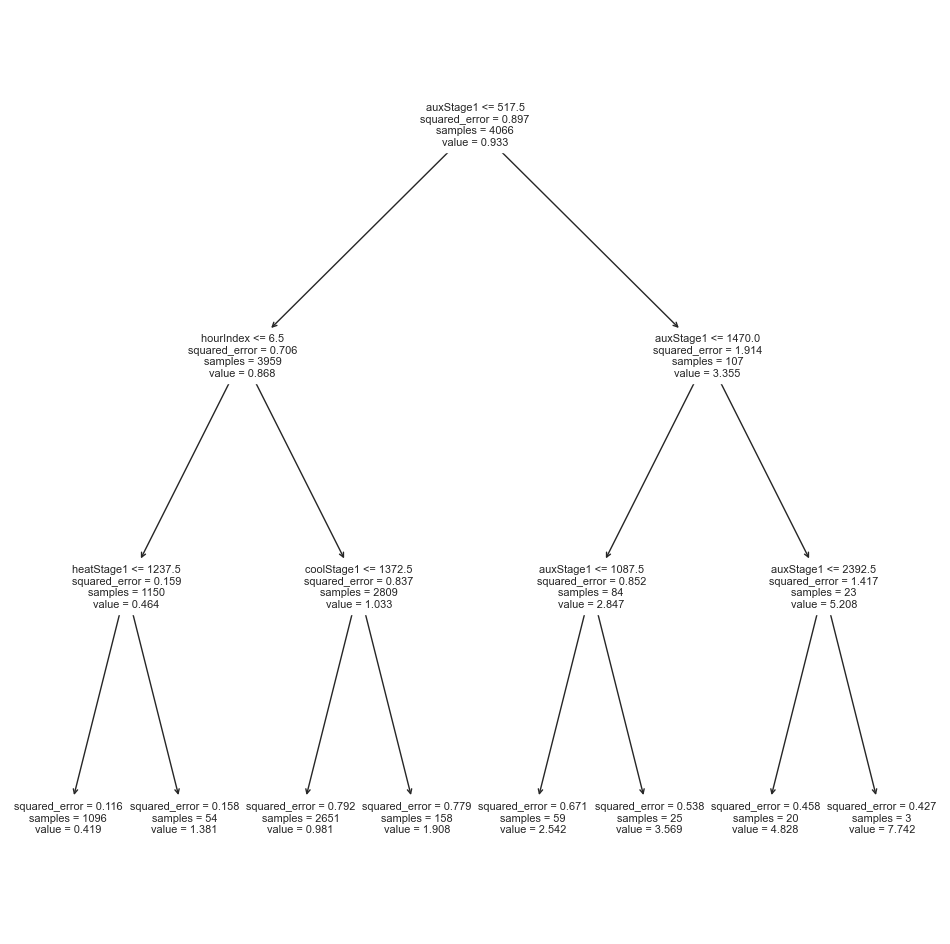

In [21]:
reg = DTR(max_depth=3) 
reg.fit(X_train, y_train)
plt.figure(figsize=(12,12))
plot_tree(reg, feature_names=feature_names);

In [18]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train) 
kfold = skm.KFold(5,
shuffle=True,
random_state=10) 
grid = skm.GridSearchCV(reg,
{'ccp_alpha': ccp_path.ccp_alphas},
refit=True,
cv=kfold, scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

In [19]:
best_ = grid.best_estimator_
print("MSE:", np.mean((y_test - best_.predict(X_test))**2))

MSE: 0.6152471972946525


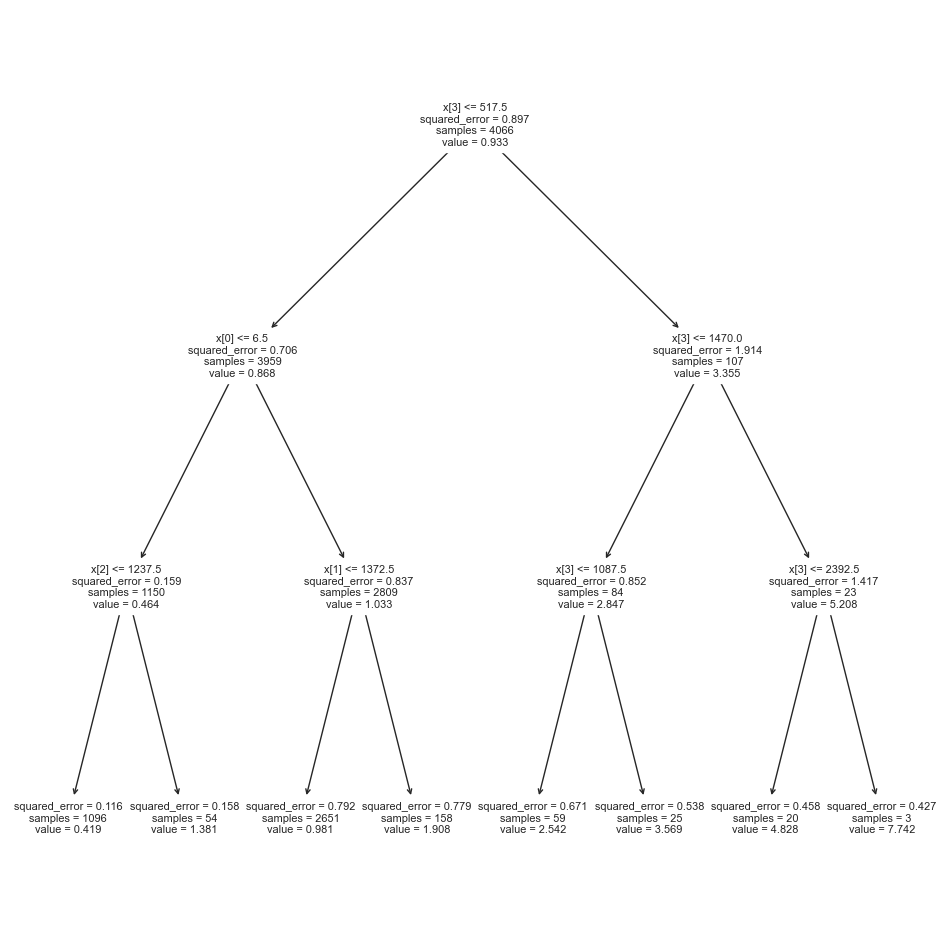

In [20]:
plt.figure(figsize=(12,12))
plot_tree(G.best_estimator_);

In [51]:
smalldf.usage.mean()

0.9301690340350186